# Building a Neural Network to recognize Quick Draw doodles

The general idea of this notebook will be to try and test the solutions provided by Google AI and other kagglers to the classification problem linked to the Quick Draw dataset.

## Google AI suggestion

Building a Neural Network dataset introducting LSTM layers. Indeed, they want to take into account the notion of temporality by using layers that keep track of what happened before. They also do not want to use a Neural Network that would consider the input as an image by using 1D Convolutionnal Layers. It's worth a try ! 

Tutorial of Google AI's solution in Tensorflow right here : https://www.tensorflow.org/tutorials/sequences/recurrent_quickdraw

## Considering the dataset as images only

But here, we will try to work on a simpler idea which consists in interpreting the vectors of coordinates of the dataset as images only. Thus, we could use classical Neural Networks architectures that would consist in a succession of 2D Convolutionnal, Max Pooling and Flatten Layers then a FC layer.

Exemple of such a solution in Tensorflow here : https://www.kaggle.com/gaborfodor/black-white-cnn-lb-0-75/notebook

## Loading packages

In [1]:
# To run only on Google Colab
google_collab = False

if google_collab:
    from os.path import exists
    from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
    platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
    cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
    accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

    !pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
    import torch

    from google.colab import drive
    drive.mount('/content/drive')

In [2]:
import pandas as pd 
import numpy as np 
import ast
import matplotlib.pyplot as plt
import cv2
import keras.utils
import os
import glob
import torch
import torchvision
from torchvision import models,transforms,datasets
import torch.nn as nn
import torch.nn.functional as F
import pickle

%matplotlib inline

Using TensorFlow backend.
/Users/samimhirech/anaconda/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


## Reading data

In [34]:
data_dir = '../../data_quick_draw/'
model_dir = '../output/model/'
mapping_dir = '../output/mapping/'
results_dir = '../output/results/'

In [3]:
axe = pd.read_csv(os.path.join(data_dir, 'axe.csv'), 
                  index_col='key_id', 
                  nrows=100).drop(['countrycode', 'recognized', 'timestamp'], axis=1)

In [4]:
axe.drawing = axe.drawing.map(ast.literal_eval)

In [5]:
first_ten_ids = axe.iloc[:5].index
axe_images = axe.loc[first_ten_ids, 'drawing']

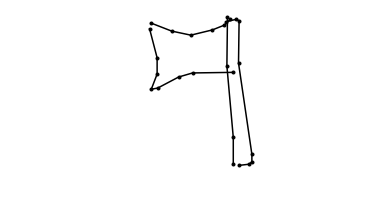

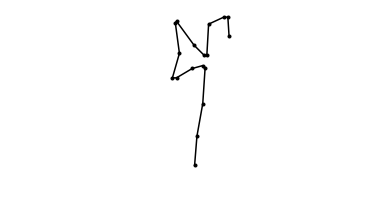

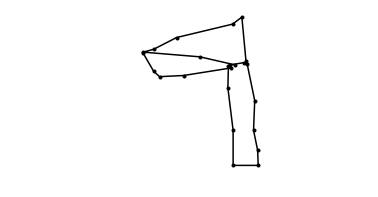

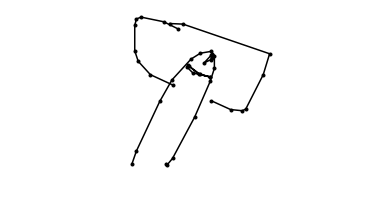

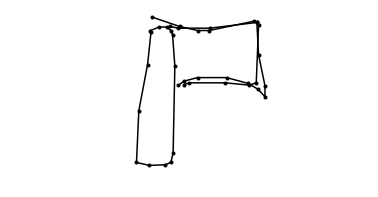

In [6]:
for index, axe_drawing in enumerate(axe_images, 0):
    
    plt.figure(figsize=(6,3))

    for x,y in axe_drawing:
        plt.plot(x, y, marker='.', color='black')
        plt.axis('off')

    plt.gca().invert_yaxis()
    plt.axis('equal')
    plt.show()  

## Transforming data : from strokes to image

In [7]:
BASE_SIZE = 256

def draw_cv2(raw_strokes, size=256, lw=6):
    img = np.zeros((BASE_SIZE, BASE_SIZE), np.uint8)
    for stroke in raw_strokes:
        for i in range(len(stroke[0]) - 1):
            _ = cv2.line(img, (stroke[0][i], stroke[1][i]), (stroke[0][i + 1], stroke[1][i + 1]), 255, lw)
    if size != BASE_SIZE:
        return cv2.resize(img, (size, size))
    else:
        return img

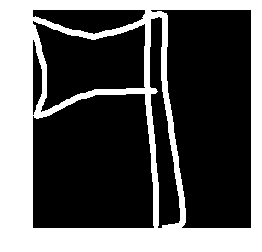

In [13]:
axe_strokes = axe.loc[axe.index[0], 'drawing']
img = draw_cv2(axe_strokes)

plt.imshow(img, cmap=plt.cm.gray)
plt.axis('off')
plt.show()

In [14]:
def df_to_image_array(df, size, lw=6):
    x = np.zeros((len(df), size, size))
    for i, raw_strokes in enumerate(df.drawing.values):
        x[i] = draw_cv2(raw_strokes, size=size, lw=lw)
    x = x / 255.
    x = x.reshape((len(df), size, size)).astype(np.float32)
    return x

## Building our train and test functions

We will first design our train and test functions. These functions can be used directly to train and test all the classification problems and all the architectures we will define in the whole notebook.

In [15]:
use_gpu = torch.cuda.is_available()

In [16]:
def train(model,data_loader,loss_fn,optimizer,n_epochs=1):
    
    model.train(True)
    if use_gpu:
        model.cuda()
    
    loss_train = np.zeros(n_epochs)
    acc_train = np.zeros(n_epochs)
    
    for epoch_num in range(n_epochs):
        running_corrects = 0.0
        running_loss = 0.0
        size = 0

        for data in data_loader:
            inputs, labels = data
            bs = labels.size(0)
            
            if use_gpu:
                inputs = inputs.cuda()
                labels = labels.cuda()
        
            outputs = model(inputs)        
            loss = loss_fn(outputs, labels)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == labels)
            running_loss += loss.data
            
            size += bs
        
        epoch_loss = running_loss / size
        epoch_acc = running_corrects.item() / size
        loss_train[epoch_num] = epoch_loss
        acc_train[epoch_num] = epoch_acc
        print('Train - Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss, epoch_acc))
        
    return loss_train, acc_train

In [17]:
def test(model,data_loader):
    model.train(False)

    running_corrects = 0.0
    running_loss = 0.0
    size = 0

    for data in data_loader:
        inputs, labels = data    
        bs = labels.size(0)
        
        if use_gpu:
            inputs = inputs.cuda()
            labels = labels.cuda()
        
        outputs = model(inputs)        
        loss = loss_fn(outputs, labels)

        _, preds = torch.max(outputs, 1)
        running_corrects += torch.sum(preds == labels)
        running_loss += loss.data
         
        size += bs

    print('Test - Loss: {:.4f} Acc: {:.4f}'.format(running_loss / size, running_corrects.item() / size))

In [35]:
def test_results(model,data_loader):
    model.train(False)

    running_corrects = 0.0
    running_loss = 0.0
    size = 0
    all_preds = []
    all_labels = []

    for data in data_loader:
        inputs, labels = data    
        bs = labels.size(0)
        
        if use_gpu:
            inputs = inputs.cuda()
            labels = labels.cuda()
        
        outputs = model(inputs)        
        loss = loss_fn(outputs, labels)

        _, preds = torch.max(outputs, 1)
        running_corrects += torch.sum(preds == labels)
        running_loss += loss.data
        
        preds = preds.cpu()
        labels = labels.cpu()
        
        all_preds = np.append(all_preds, preds.numpy())
        all_labels = np.append(all_labels, labels.numpy())
         
        size += bs
        
    return all_preds, all_labels

    print('Test - Loss: {:.4f} Acc: {:.4f}'.format(running_loss / size, running_corrects.item() / size))

In [36]:
def get_results(model, test_loader):
    model.eval()

    all_preds, all_labels = test_results(model,test_loader)

    result_dic = {}
    for key, value in mapping.items():
        pred_of_class = all_preds[(all_labels == value)]
        rate = sum(pred_of_class == value)/len(pred_of_class)
        result_dic[key] = rate
    
    return result_dic

Now the architectures of the train and the test functions are ready. The only things we will need to change from now on will be the classifier function and the training and testing datasets. 

## Beginning with a multi-class classification problem : Axes, Ladders and Dolphins

In [21]:
axe = pd.read_csv(os.path.join(data_dir, 'axe.csv'),
                  index_col='key_id', 
                  nrows=1000).drop(['countrycode', 'recognized', 'timestamp'], axis=1)
ladder = pd.read_csv(os.path.join(data_dir, 'ladder.csv'),
                     index_col='key_id', 
                     nrows=1000).drop(['countrycode', 'recognized', 'timestamp'], axis=1)
dolphin = pd.read_csv(os.path.join(data_dir, 'dolphin.csv'),
                     index_col='key_id', 
                      nrows=1000).drop(['countrycode', 'recognized', 'timestamp'], axis=1)

df_train = pd.concat([axe[:800], ladder[:800], dolphin[:800]], axis=0)
df_test = pd.concat([axe[800:], ladder[800:], dolphin[800:]], axis=0)

df_train.drawing = df_train.drawing.map(ast.literal_eval)
df_test.drawing = df_test.drawing.map(ast.literal_eval)

mapping = {'axe' : 0, 
           'ladder' : 1, 
           'dolphin' : 2}

df_train.y = df_train.word.replace(mapping)
df_test.y = df_test.word.replace(mapping)

In [23]:
x_train = df_to_image_array(df=df_train, size=256)
y_train = df_train.y

x_test = df_to_image_array(df=df_test, size=256)
y_test = df_test.y

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(2400, 256, 256)
(2400,)
(600, 256, 256)
(600,)


In [24]:
bs = 64 
kwargs = {'num_workers': 1, 'pin_memory': True} if use_gpu else {}

train_dataset = [[torch.from_numpy(e.astype(np.float32)).unsqueeze(0), 
                   torch.from_numpy(np.array(l).astype(np.int64))] for e, l in zip(x_train, y_train)]
test_dataset = [[torch.from_numpy(e.astype(np.float32)).unsqueeze(0), 
                   torch.from_numpy(np.array(l).astype(np.int64))] for e, l in zip(x_test, y_test)]

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=bs, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=bs, shuffle=True, **kwargs)

Building an very simple classifier with one Conv 2D Layer, one Max Pooling Layer and an activation function. 

In [27]:
class simple_classifier(nn.Module):
    
    def __init__(self):
        super(simple_classifier, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=4, kernel_size=3, padding=1)
        self.fc = nn.Linear(in_features=4096, out_features=3)
        
    def forward(self,x):
        batch_size = x.shape[0]
        x = self.conv1(x)
        x = F.max_pool2d(x, kernel_size=8, stride=8)
        x = x.reshape(batch_size,4096)
        x = self.fc(x)
        x = F.log_softmax(x)
        return x

In [28]:
conv_class = simple_classifier()
loss_fn = nn.NLLLoss(size_average=False)
learning_rate = 1e-3
optimizer_cl = torch.optim.SGD(conv_class.parameters(), lr=learning_rate)
l_t, a_t = train(conv_class,train_loader,loss_fn,optimizer_cl,n_epochs = 5)

/Users/samimhirech/anaconda/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/Users/samimhirech/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:14: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Train - Loss: 0.5661 Acc: 0.7812
Train - Loss: 0.3886 Acc: 0.8654
Train - Loss: 0.3546 Acc: 0.8829
Train - Loss: 0.3290 Acc: 0.8950
Train - Loss: 0.3121 Acc: 0.8979


In [29]:
test(conv_class,test_loader)

/Users/samimhirech/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:14: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Test - Loss: 0.5622 Acc: 0.8183


In [33]:
torch.save(conv_class, os.path.join(output_dir, 'model_3_1000.pt'))
pickle.dump(mapping, open(os.path.join(output_dir,'map_3_1000.pickle'), 'wb'))

/Users/samimhirech/anaconda/lib/python3.6/site-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type simple_classifier. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [39]:
results = get_results(conv_class, test_loader)
pickle.dump(results, open(os.path.join(results_dir,'results_3_1000.pickle'), 'wb'))

/Users/samimhirech/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:14: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


## Training for all csv files

In [42]:
data_files = glob.glob(data_dir + "/*.csv")
train_list = []
test_list = []

whole_size = 500
train_size = 460

for file in data_files:
    df = pd.read_csv(file, 
                     index_col='key_id', 
                     nrows=whole_size).drop(['countrycode', 'recognized', 'timestamp'], axis=1)
    train_list.append(df[:train_size])
    test_list.append(df[train_size:])

df_train = pd.concat(train_list, axis=0)
df_test = pd.concat(test_list, axis=0)

df_train.drawing = df_train.drawing.map(ast.literal_eval)
df_test.drawing = df_test.drawing.map(ast.literal_eval)

mapping = {x.replace(data_dir,'')[:-4]:i for i, x in enumerate(data_files)}
num_classes = len(mapping)

df_train.y = df_train.word.replace(mapping)
df_test.y = df_test.word.replace(mapping)

In [ ]:
x_train = df_to_image_array(df=df_train, size=96)
y_train = df_train.y

x_test = df_to_image_array(df=df_test, size=96)
y_test = df_test.y

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

In [ ]:
bs = 64 
kwargs = {'num_workers': 1, 'pin_memory': True} if use_gpu else {}

train_dataset = [[torch.from_numpy(e.astype(np.float32)).unsqueeze(0), 
                   torch.from_numpy(np.array(l).astype(np.int64))] for e, l in zip(x_train, y_train)]
test_dataset = [[torch.from_numpy(e.astype(np.float32)).unsqueeze(0), 
                   torch.from_numpy(np.array(l).astype(np.int64))] for e, l in zip(x_test, y_test)]

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=bs, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=bs, shuffle=True, **kwargs)

In [ ]:
class classifier_all(nn.Module):
    
    def __init__(self):
        super(classifier_all, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=4, kernel_size=3, padding=1)
        self.fc = nn.Linear(in_features=576, out_features=num_classes)
        
    def forward(self,x):
        batch_size = x.shape[0]
        x = self.conv1(x)
        x = F.max_pool2d(x, kernel_size=8, stride=8)
        x = x.reshape(batch_size,576)
        x = self.fc(x)
        x = F.log_softmax(x)
        return x


use_gpu = torch.cuda.is_available()
if use_gpu:
    classifier = classifier.cuda()

In [ ]:
conv_class_all = classifier_all()
loss_fn = nn.NLLLoss(size_average=False)
learning_rate = 1e-3
optimizer_cl = torch.optim.SGD(conv_class_all.parameters(), lr=learning_rate)
l_t, a_t = train(conv_class_all,train_loader,loss_fn,optimizer_cl,n_epochs = 10)

In [ ]:
test(conv_class_all,test_loader)

In [ ]:
torch.save(conv_class_all, '../output/conv_all.pt')

In [ ]:
pickle.dump(mapping, open('../output/map_conv_all.pickle', 'wb'))

## Training with customized ResNet 18 

In [ ]:
dir_path = '../../data_quick_draw/'
files = glob.glob(dir_path + "/*.csv")
train_list = []
test_list = []

whole_size = 500
train_size = 460

for file in files:
    df = pd.read_csv(file, 
                     index_col='key_id', 
                     nrows=whole_size).drop(['countrycode', 'recognized', 'timestamp'], axis=1)
    train_list.append(df[:train_size])
    test_list.append(df[train_size:])

df_train = pd.concat(train_list, axis=0)
df_test = pd.concat(test_list, axis=0)

df_train.drawing = df_train.drawing.map(ast.literal_eval)
df_test.drawing = df_test.drawing.map(ast.literal_eval)

mapping = {x.replace('../../data_quick_draw/','').replace(" ","_")[:-4]:i for i, x in enumerate(files)}
num_classes = len(mapping)

df_train.y = df_train.word.replace(mapping)
df_test.y = df_test.word.replace(mapping)

In [ ]:
x_train = df_to_image_array(df=df_train, size=224)
y_train = df_train.y

x_test = df_to_image_array(df=df_test, size=224)
y_test = df_test.y

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

In [ ]:
bs = 64 
kwargs = {'num_workers': 1, 'pin_memory': True} if use_gpu else {}

train_dataset = [[torch.from_numpy(e.astype(np.float32)).unsqueeze(0), 
                   torch.from_numpy(np.array(l).astype(np.int64))] for e, l in zip(x_train, y_train)]
test_dataset = [[torch.from_numpy(e.astype(np.float32)).unsqueeze(0), 
                   torch.from_numpy(np.array(l).astype(np.int64))] for e, l in zip(x_test, y_test)]

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=bs, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=bs, shuffle=True, **kwargs)

In [ ]:
class classifier_resnet(nn.Module):
    
    def __init__(self):
        super(classifier_resnet,self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, stride=2, padding=3)
        # Downloading architecture of resnet18
        self.resnet = models.resnet18(pretrained=False)
        # Deleting last layer of resnet18 because it has out_features = 1000 by default (the 1000 classes of ImageNet)
        self.base = nn.Sequential(*list(self.resnet.children())[1:-1])
        # Adding FC layer
        self.fc = nn.Linear(2048,num_classes)

    def forward(self, x):
        batch_size = x.shape[0]
        x = self.conv1(x)
        x = self.base(x)
        x = x.reshape(batch_size, -1)
        x = self.fc(x)
        x = F.log_softmax(x)
        return x

In [ ]:
resnet_model = classifier_resnet()
loss_fn = nn.NLLLoss(size_average=False)
learning_rate = 1e-3
optimizer_cl = torch.optim.SGD(resnet_model.parameters(), lr=learning_rate)
l_t, a_t = train(resnet_model,train_loader,loss_fn,optimizer_cl,n_epochs = 10)

In [ ]:
test(resnet_model,test_loader)

In [ ]:
torch.save(resnet_model, '../output/model_resnet.pt')

In [ ]:
pickle.dump(mapping, open('../output/map_resnet.pickle', 'wb'))

## Training with architecture of a Kaggler

In [ ]:
dir_path = '../../data_quick_draw/'
files = glob.glob(dir_path + "/*.csv")
train_list = []
test_list = []

whole_size = 500
train_size = 460

for file in files:
    df = pd.read_csv(file, 
                     index_col='key_id', 
                     nrows=whole_size).drop(['countrycode', 'recognized', 'timestamp'], axis=1)
    train_list.append(df[:train_size])
    test_list.append(df[train_size:])

df_train = pd.concat(train_list, axis=0)
df_test = pd.concat(test_list, axis=0)

df_train.drawing = df_train.drawing.map(ast.literal_eval)
df_test.drawing = df_test.drawing.map(ast.literal_eval)

mapping = {x.replace('../../data_quick_draw/','').replace(" ","_")[:-4]:i for i, x in enumerate(files)}
num_classes = len(mapping)

df_train.y = df_train.word.replace(mapping)
df_test.y = df_test.word.replace(mapping)

In [ ]:
x_train = df_to_image_array(df=df_train, size=32)
y_train = df_train.y

x_test = df_to_image_array(df=df_test, size=32)
y_test = df_test.y

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

In [ ]:
bs = 64 
kwargs = {'num_workers': 1, 'pin_memory': True} if use_gpu else {}

train_dataset = [[torch.from_numpy(e.astype(np.float32)).unsqueeze(0), 
                   torch.from_numpy(np.array(l).astype(np.int64))] for e, l in zip(x_train, y_train)]
test_dataset = [[torch.from_numpy(e.astype(np.float32)).unsqueeze(0), 
                   torch.from_numpy(np.array(l).astype(np.int64))] for e, l in zip(x_test, y_test)]

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=bs, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=bs, shuffle=True, **kwargs)

In [ ]:
class classifier_kaggle(nn.Module):
    
    def __init__(self):
        super(classifier_kaggle,self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=128, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3)
        self.dense1 = nn.Linear(3136, 1024)
        self.dense2 = nn.Linear(1024, num_classes)
    def forward(self, x):
        batch_size = x.shape[0]
        x = self.conv1(x)
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        x = self.conv2(x)
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        x = x.reshape(batch_size, -1)
        x = self.dense1(x)
        x = F.relu(x)
        x = self.dense2(x)
        x = F.log_softmax(x)
        return x

In [ ]:
kaggle_model = classifier_kaggle()
loss_fn = nn.NLLLoss(size_average=False)
learning_rate = 1e-3
optimizer_cl = torch.optim.SGD(kaggle_model.parameters(), lr=learning_rate)
l_t, a_t = train(kaggle_model,train_loader,loss_fn,optimizer_cl,n_epochs = 10)

In [ ]:
test(kaggle_model,test_loader)

In [ ]:
torch.save(kaggle_model, '../output/model_kaggle.pt')

In [ ]:
pickle.dump(mapping, open('../output/map_kaggle.pickle', 'wb'))

## Finding results on test sets by label

In [ ]:
model.eval()

all_preds, all_labels = test_results(model,test_loader)

result_dic = {}
for key, value in mapping.items():
    pred_of_class = all_preds[(all_labels == value)]
    rate = sum(pred_of_class == value)/len(pred_of_class)
    result_dic[key] = rate

pickle.dump(result_dic, open('/content/drive/My Drive/QuickDraw/output/results_340_2000.pickle', 'wb'))

## Trainining models on GPU 

Since our dataset is composed of 50 million drawings and that we do not have any GPU on our computers, we have decided to train our models on Google Colaboratory and use their GPU. 

A part of our preprocessing is done with pandas, which stores the data on the RAM, so we were not able to load all the data on Google Colab since it proposes a limited RAM of 12.7 Go. So we tried different experiments and trainings to test the limits of Google Colab's RAM. 

### 20 labels and 20000 images by label

- Training set : 20000 images by label
- Testing set : 5000 images by label

In [ ]:
results = pickle.load(open('../output/results_20_25000.pickle', "rb"))

In [ ]:
results_df = pd.DataFrame(pd.Series(results)).reset_index()
results_df.columns = ['label', 'perc']

In [ ]:
results_df.sort_values('perc', ascending=False)[:10]

In [ ]:
results_df.sort_values('perc')[:10]

### 114 labels and 460 images by label

- Training set : 460 images by label
- Testing set : 40 images by label

In [ ]:
results = pickle.load(open('../output/results_114_500.pickle', "rb"))

In [ ]:
results_df = pd.DataFrame(pd.Series(results)).reset_index()
results_df.columns = ['label', 'perc']

In [ ]:
results_df.sort_values('perc', ascending=False)[:10]

In [ ]:
results_df.sort_values('perc')[:10]

### 114 labels and 3000 images 

- Training set : 3000 images by label
- Testing set : 500 images by label

In [ ]:
results = pickle.load(open('../output/results_114_3500.pickle', "rb"))

In [ ]:
results_df = pd.DataFrame(pd.Series(results)).reset_index()
results_df.columns = ['label', 'perc']

In [ ]:
results_df.sort_values('perc', ascending=False)[:10]

In [ ]:
results_df.sort_values('perc')[:10]

### 340 labels and 800 images 

- Training set : 800 images by label
- Testing set : 200 images by label

In [ ]:
results = pickle.load(open('../output/results_340_1000.pickle', "rb"))

In [ ]:
results_df = pd.DataFrame(pd.Series(results)).reset_index()
results_df.columns = ['label', 'perc']

In [ ]:
results_df.sort_values('perc', ascending=False)[:10]

In [ ]:
results_df.sort_values('perc')[:10]

### 340 labels and 1600 images 

- Training set : 1600 images by label
- Testing set : 400 images by label

In [ ]:
loss = [2.8013, 1.9212, 1.6502, 1.4501, 1.2705, 1.0988, 0.9333, 0.7790, 0.6497, 0.5403]
accuracy = [0.3895, 0.5487, 0.6040, 0.6459, 0.6829, 0.7200, 0.7561, 0.7918, 0.8200, 0.8459]

In [ ]:
plt.plot(np.arange(0,10), loss)
plt.ylabel('NLLLoss')
plt.xlabel('Epoch')

In [ ]:
plt.plot(np.arange(0,10), accuracy)
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

In [ ]:
results = pickle.load(open('../output/results_340_2000.pickle', "rb"))

In [ ]:
results_df = pd.DataFrame(pd.Series(results)).reset_index()
results_df.columns = ['label', 'perc']

In [ ]:
results_df.sort_values('perc', ascending=False)[:10]

In [ ]:
results_df.sort_values('perc')[:10]

## Testing the model with one image 

In [ ]:
ex_path = '../../data_quick_draw/dolphin.csv'

ex_df = pd.read_csv(ex_path, index_col='key_id', nrows=3).drop(['countrycode', 'recognized', 'timestamp'], axis=1)

ex_df.drawing = ex_df.drawing.map(ast.literal_eval)

plt.imshow(draw_cv2(ex_df.loc[ex_df.index[1], 'drawing']))
plt.show()

In [ ]:
mapping = pickle.load(open('/content/drive/My Drive/QuickDraw/output/map_340_2000.pickle', "rb"))

In [ ]:
ex_input = torch.from_numpy(draw_cv2(ex_strokes, size = 32).astype(np.float32)).unsqueeze(0)

In [ ]:
model(ex_input)

To be continued ...